In [31]:
%matplotlib inline
#!/usr/bin/env python3

import numpy as np
import matplotlib.pyplot as plt
import random as rd
from mpl_toolkits.mplot3d import Axes3D
from sklearn.utils import check_random_state
from scipy.stats import multivariate_normal
import time
import math as m

## Différentes idées pour l'implémentation de l'algorithme de sampling gaussien de matrice SPD de dimension 2

Puisque cet algorithme doit pouvoir être utilisé facilement il doit respecter certains critères.
1) minimiser la complexité temporelle
2) minimiser la complexité spatiale
3) sampler le nombre exact de matrices demandé par l'utilisateur
4) être résistant à la casse (ne doit jamais planter)

### L'algorithme implémenté par Mr. Pedro L.C. Rodrigues vérifie les conditions 1) et 4).

In [155]:
start = time.time()
N = 10_000
s = 1.0
T = 10

b = np.random.binomial(1, 0.5, N)
mu0 = np.array([s**2/2, -s**2/2])
cv0 = s**2*np.eye(2)
mu1 = np.array([-s**2/2, s**2/2])
cv1 = s**2*np.eye(2)

u0 = np.random.rand(sum(b > 0))
r0_candidates = multivariate_normal.rvs(
    mean=mu0, 
    cov=cv0, 
    size=sum(b > 0))
u1 = np.random.rand(N - sum(b > 0))
r1_candidates = multivariate_normal.rvs(
    mean=mu1, 
    cov=cv1, 
    size=N - sum(b > 0))

def test0(r, s):
    mu0 = np.array([s**2/2, -s**2/2])
    cv0 = s**2*np.eye(2)    
    if (r[0] - r[1]) < 0:
        return 0
    else:
        M = np.pi*(s**2)*np.exp(s**2/4)
        num = np.exp(-1/(2*s**2) * np.sum(r**2)) * np.sinh((r[0] - r[1])/2) * 1/M
        den = multivariate_normal.pdf(r, mean=mu0, cov=cv0)
        return num / den

def test1(r, s):
    mu1 = np.array([-s**2/2, s**2/2])
    cv1 = s**2*np.eye(2)    
    if (r[1] - r[0]) < 0:
        return 0
    else:
        M = np.pi*(s**2)*np.exp(s**2/4)
        num = np.exp(-1/(2*s**2) * np.sum(r**2)) * np.sinh((r[1] - r[0])/2) * 1/M
        den = multivariate_normal.pdf(r, mean=mu1, cov=cv1)
        return num / den

t0 = np.array([test0(ri, s) for ri in r0_candidates])
r0 = r0_candidates[u0 < t0]
t1 = np.array([test1(ri, s) for ri in r1_candidates])
r1 = r1_candidates[u1 < t1]
r = np.concatenate([r0, r1])

end  = time.time()
print("temps par matrices en e-5 secondes:", (end - start)*N/r.shape[0]) #temps par matrices en e-5 secondes
print("nombre de couple générée:", r.shape[0])

temps par matrices en e-5 secondes: 3.0048496029325316
nombre de couple générée: 5168


### Ci-dessous, une première idée d'algorithme qui vérifie les conditions 1) et 3). 

In [164]:
start2 = time.time()

def rejection_sampling_A_2(sigma, r):
    MU_A = np.array([sigma**2/2, -sigma**2/2])
    COV_MATRIX = (sigma**2)*np.eye(2)
    M = np.pi*(sigma**2)*np.exp(sigma**2/4)
    if r[0] >= r[1]:
        M = np.pi*(sigma**2)*np.exp(sigma**2/4)
        num = np.exp(-1/(2*sigma**2) * np.sum(r**2)) * np.sinh((r[0] - r[1])/2) * 1/M
        den = multivariate_normal.pdf(r, mean=MU_A, cov=COV_MATRIX)
        return num / den
    return 0
    
def rejection_sampling_B_2(sigma, r):
    MU_B = np.array([-sigma**2/2, sigma**2/2])
    COV_MATRIX = (sigma**2)*np.eye(2)
    M = np.pi*(sigma**2)*np.exp(sigma**2/4)
    if r[0] < r[1]:
        M = np.pi*(sigma**2)*np.exp(sigma**2/4)
        num = np.exp(-1/(2*sigma**2) * np.sum(r**2)) * np.sinh((r[1] - r[0])/2)
        den = multivariate_normal.pdf(r, mean=MU_B, cov=COV_MATRIX)*M
        return num/den
    return 0


def rejection_sampling_2(sigma, n):
    MU_A = np.array([sigma**2/2, -sigma**2/2])
    MU_B = np.array([-sigma**2/2, sigma**2/2])
    COV_MATRIX = (sigma**2)*np.eye(2)
    M = np.pi*(sigma**2)*np.exp(sigma**2/4)
    RES = []
    cpt = 0
    B = np.random.binomial(1, 0.5, 2*n)    # le 2n est choisie arbitrairement et pose problème
    M1 = multivariate_normal.rvs(MU_A, COV_MATRIX, 2*n)  # le 2n est choisie arbitrairement et pose problème
    M2 = multivariate_normal.rvs(MU_B, COV_MATRIX, 2*n)   # le 2n est choisie arbitrairement et pose problème
    N = np.random.rand(2*n)
    i = 0
    k = 0
    l = 0
    while cpt != n:
        if B[i] == 1:
            r = M1[k]
            k+=1
            res = rejection_sampling_A_2(sigma, r)
            if N[i] < res:
                RES.append(r)
                cpt += 1
            i+=1
        else:
            r = M2[l]
            l+=1
            res = rejection_sampling_B_2(sigma, r)
            if N[i] < res:
                RES.append(r)
                cpt+=1
            i+=1
    return np.array(RES)

R_2 = rejection_sampling_2(1, 10000)
end2 = time.time()

print("temps par matrices en e-5 secondes :" ,(end2 - start2)*10000/R_2.shape[0]) #temps par matrices en e-5 secondes

print("nombre de couple générée:",np.shape(R_2)[0])

temps par matrices en e-5 secondes : 2.9673287868499756
nombre de couple générée: 10000


Le problème principale de cet algortihme est qu'on doive determiner à l'avance une approximation du nombre de vecteur à 2 dimensions qui seront acceptées par l'algo. Si on accepte $f$% des matrices il suffira de remplacer les $2n$ dans M1, M2 et N par $n/f$ ou $100 + 2n/f$ par exemple.

Cependant ce f que l'on cherche qui dépend de sigma est exactement la constante de normalisation qui nous est inconnu, divisée par $M$.

Cependant on peut en trouver une approximation qui permettrai de générer assez d'éléments de M1, M2 et N sans jamais faire planter l'algo (cas qui arrive quand la shape de M1, M2 ou N est trop faible)

C'est ce que nous verrons à la fin de ce document




### Voici une deuxième idée d'algorithme qui vérifie les conditions 2), 3) et 4).

In [165]:
start1 = time.time()
def rejection_sampling_A(sigma, r):
    MU_A = np.array([sigma**2/2, -sigma**2/2])
    COV_MATRIX = (sigma**2)*np.eye(2)
    M = np.pi*(sigma**2)*np.exp(sigma**2/4)
    if r[0] >= r[1]:
        M = np.pi*(sigma**2)*np.exp(sigma**2/4)
        num = np.exp(-1/(2*sigma**2) * np.sum(r**2)) * np.sinh((r[0] - r[1])/2) * 1/M
        den = multivariate_normal.pdf(r, mean=MU_A, cov=COV_MATRIX)
        return num / den
    return 0
    
def rejection_sampling_B(sigma, r):
    MU_B = np.array([-sigma**2/2, sigma**2/2])
    COV_MATRIX = (sigma**2)*np.eye(2)
    M = np.pi*(sigma**2)*np.exp(sigma**2/4)
    if r[0] < r[1]:
        M = np.pi*(sigma**2)*np.exp(sigma**2/4)
        num = np.exp(-1/(2*sigma**2) * np.sum(r**2)) * np.sinh((r[1] - r[0])/2)
        den = multivariate_normal.pdf(r, mean=MU_B, cov=COV_MATRIX)*M
        return num/den
    return 0


def rejection_sampling(sigma, n):
    MU_A = np.array([sigma**2/2, -sigma**2/2])
    MU_B = np.array([-sigma**2/2, sigma**2/2])
    COV_MATRIX = (sigma**2)*np.eye(2)
    M = np.pi*(sigma**2)*np.exp(sigma**2/4)
    RES = []
    cpt = 0
    while cpt != n:
        if np.random.binomial(1, 0.5, 1) == 1:  # correction du pb du prgm précédent
            r = multivariate_normal.rvs(MU_A, COV_MATRIX, 1) # correction du pb du prgm précédent
            res = rejection_sampling_A(sigma, r) 
            if np.random.rand(1) < res:   # correction du pb du prgm précédent
                RES.append(r)
                cpt += 1
        else:
            r = multivariate_normal.rvs(MU_B, COV_MATRIX, 1)  # correction du pb du prgm précédent
            res = rejection_sampling_B(sigma, r)
            if np.random.rand(1) < res:  # correction du pb du prgm précédent
                RES.append(r)
                cpt+=1
    return np.array(RES)

R = rejection_sampling(1, 10000)
end1 = time.time()

print("temps par matrices en e-5 secondes:",(end1 - start1)*10000/R.shape[0]) #temps par matrices en e-5 secondes

print("nombre de couple générée:", R.shape[0])

temps par matrices en e-5 secondes: 7.63086462020874
nombre de couple générée: 10000


Cet algorithme ne gérère que ce qui est nécessaire 


(ex: dans cet algo on a multivariate_normal.rvs(MU_A, COV_MATRIX, 1) 

au lieu multivariate_normal.rvs(MU_A, COV_MATRIX, 2*n) dans l'algo précédent ou encore, 


np.random.binomial(1, 0.5, 1) au lieu de np.random.binomial(1, 0.5, 2*n), ...)

 ce qui permet gagner beaucoup d'espace de stockage, de ne jamais planter mais c'est malheureusement plus lent).

### Reprenons ce qui a été dis précédemment sur la probabilité d'acceptation de notre algorithme

L'algo suivant permet par la suite de tracer la fameuse fréquence que l'on cherche ie de tracer la constante de normalisation (dépendant de sigma) qui nous est inconnu, divisée par $M$

(Il s'agit enfaite du même algo que le premier présenté dans ce notebook)

In [162]:
start2 = time.time()

def rejection_sampling_A_3(sigma, r):
    MU_A = np.array([sigma**2/2, -sigma**2/2])
    COV_MATRIX = (sigma**2)*np.eye(2)
    M = np.pi*(sigma**2)*np.exp(sigma**2/4)
    if r[0] >= r[1]:
        M = np.pi*(sigma**2)*np.exp(sigma**2/4)
        num = np.exp(-1/(2*sigma**2) * np.sum(r**2)) * np.sinh((r[0] - r[1])/2) * 1/M
        den = multivariate_normal.pdf(r, mean=MU_A, cov=COV_MATRIX)
        return num / den
    return 0
    
def rejection_sampling_B_3(sigma, r):
    MU_B = np.array([-sigma**2/2, sigma**2/2])
    COV_MATRIX = (sigma**2)*np.eye(2)
    M = np.pi*(sigma**2)*np.exp(sigma**2/4)
    if r[0] < r[1]:
        M = np.pi*(sigma**2)*np.exp(sigma**2/4)
        num = np.exp(-1/(2*sigma**2) * np.sum(r**2)) * np.sinh((r[1] - r[0])/2)
        den = multivariate_normal.pdf(r, mean=MU_B, cov=COV_MATRIX)*M
        return num/den
    return 0


def rejection_sampling_3(sigma, n):
    MU_A = np.array([sigma**2/2, -sigma**2/2])
    MU_B = np.array([-sigma**2/2, sigma**2/2])
    COV_MATRIX = (sigma**2)*np.eye(2)
    M = np.pi*(sigma**2)*np.exp(sigma**2/4)
    RES = []
    cpt = 0
    B = np.random.binomial(1, 0.5, n)
    M1 = multivariate_normal.rvs(MU_A, COV_MATRIX, n)
    M2 = multivariate_normal.rvs(MU_B, COV_MATRIX, n)
    N = np.random.rand(10*n)
    i = 0
    k = 0
    l = 0
    for i in range(n):
        if B[i] == 1:
            r = M1[k]
            k+=1
            res = rejection_sampling_A_3(sigma, r)
            if N[i] < res:
                RES.append(r)
        else:
            r = M2[l]
            l+=1
            res = rejection_sampling_B_3(sigma, r)
            if N[i] < res:
                RES.append(r)
    return np.array(RES)

R_2 = rejection_sampling_3(1, 10000)
end2 = time.time()

print("temps par matrices en e-5 secondes :" ,(end2 - start2)*10000/R_2.shape[0]) #temps par matrices en e-5 secondes

print("nombre de couple générée:", np.shape(R_2)[0])

temps par matrices en e-5 secondes : 5.284182973339834
nombre de couple générée: 5179


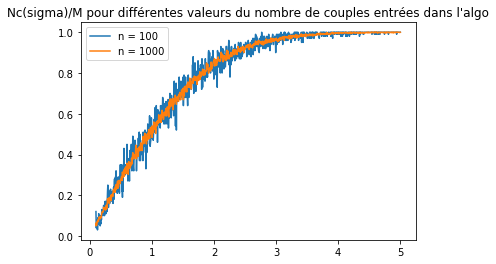

In [130]:

def NC_on_M(sigma, n):
    return rejection_sampling_3(sigma, n).shape[0]/n

X = np.array([sigma for sigma in np.linspace(0.1, 5, 1000)])
Y = np.array([NC_on_M(sigma, 100) for sigma in X])
Y2 = np.array([NC_on_M(sigma, 1000) for sigma in X])
# Y3 = np.array([NC_on_M(sigma, 10000) for sigma in X])

plt.title("Nc(sigma)/M pour différentes valeurs du nombre de couples entrées dans l'algo")
plt.plot(X, Y, label='n = 100')
plt.plot(X, Y2, label='n = 1000')
# plt.plot(X, Y3, label='n = 10000')
plt.legend()
plt.show()


Le programme suivant permet de trouver par interpolation un polynôme ressemblant à la fonction tracée ci-dessus

In [166]:
import numpy as np
import matplotlib.pyplot as plt

x_data = X
y_data = Y2

y_params = np.polyfit(x_data, y_data, 3)  # équation de degré 3

""" Nota bene : pour trouver la courbe il faut faire plusieurs essais.
Le dégré 1 convient pour des points alignés sur une ligne.
Le degré 2 et plus pour les courbes plus ou moins complexes.
N'utiliser pas un degré si élevé qu'il force la courbe a passé par tous les points,
cette courbe ne représente pas bien vos données.
"""
y = np.poly1d(y_params)

print(y)

"""
         3          2
0.01265 x - 0.1648 x + 0.7145 x - 0.03374
"""

         3          2
0.01256 x - 0.1642 x + 0.7139 x - 0.03534


'\n         3          2\n0.01265 x - 0.1648 x + 0.7145 x - 0.03374\n'

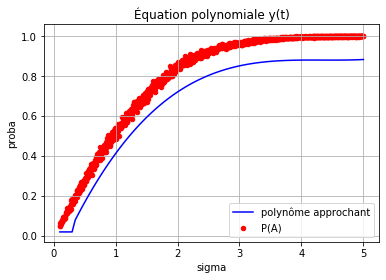

In [168]:
plt.title("Équation polynomiale y(t)")
plt.xlabel("sigma")
plt.ylabel("proba")


plt.scatter(x_data, y_data, s=20, c="red", label="P(A)")

def frequence(t):
    if t<=0.3:
        return 0.02
    else:
        return 0.01265*t**3 - 0.1648*t**2 + 0.7145*t-0.15

t = np.linspace(min(x_data), max(x_data), 100)

F = np.array([frequence(x) for x in t])

plt.plot(t, F, c="blue", label="polynôme approchant")
plt.legend()
plt.grid()
#plt.show()

On voit clairement que pour des valeurs faibles de sigma, le taux d'acceptation est très faible ce qui rend l'algo très lent et inéfficace.


En revanche pour des valeurs de sigma plus grandes, on accepte quasiment tous les couples, cela est du à la qualité de la majoration de $exp(x)-exp(-x)$ par $exp(x)$ qui est meilleure pour des grandes valeurs de x.

Il faudra donc appliquer au deuxieme algo présenté (celui qui vérifie les conditions 1) et 3)) la valeur de la fréquence trouvé par interpolation avec une marge (valeur du coeff constant du polynorme de degré 3)) afin de s'assurer que le programme ne plante pas.

On a donc le programme final:

In [163]:
start2 = time.time()


def rejection_sampling_A_4(sigma, r):
    MU_A = np.array([sigma**2/2, -sigma**2/2])
    COV_MATRIX = (sigma**2)*np.eye(2)
    M = np.pi*(sigma**2)*np.exp(sigma**2/4)
    if r[0] >= r[1]:
        M = np.pi*(sigma**2)*np.exp(sigma**2/4)
        num = np.exp(-1/(2*sigma**2) * np.sum(r**2)) * np.sinh((r[0] - r[1])/2) * 1/M
        den = multivariate_normal.pdf(r, mean=MU_A, cov=COV_MATRIX)
        return num / den
    return 0
    
def rejection_sampling_B_4(sigma, r):
    MU_B = np.array([-sigma**2/2, sigma**2/2])
    COV_MATRIX = (sigma**2)*np.eye(2)
    M = np.pi*(sigma**2)*np.exp(sigma**2/4)
    if r[0] < r[1]:
        M = np.pi*(sigma**2)*np.exp(sigma**2/4)
        num = np.exp(-1/(2*sigma**2) * np.sum(r**2)) * np.sinh((r[1] - r[0])/2)
        den = multivariate_normal.pdf(r, mean=MU_B, cov=COV_MATRIX)*M
        return num/den
    return 0


def rejection_sampling_4(sigma, n):
    N = int(n/frequence(sigma) + 200) #on fait un +200 pour contrer tou pb pour des valeurs faibles de sigma
    MU_A = np.array([sigma**2/2, -sigma**2/2])
    MU_B = np.array([-sigma**2/2, sigma**2/2])
    COV_MATRIX = (sigma**2)*np.eye(2)
    M = np.pi*(sigma**2)*np.exp(sigma**2/4)
    RES = []
    cpt = 0
    B = np.random.binomial(1, 0.5, N)
    M1 = multivariate_normal.rvs(MU_A, COV_MATRIX, N)
    M2 = multivariate_normal.rvs(MU_B, COV_MATRIX, N)
    N = np.random.rand(N)
    i = 0
    k = 0
    l = 0
    while cpt != n:
        if B[i] == 1:
            r = M1[k]
            k+=1
            res = rejection_sampling_A_4(sigma, r)
            if N[i] < res:
                RES.append(r)
                cpt += 1
            i+=1
        else:
            r = M2[l]
            l+=1
            res = rejection_sampling_B_4(sigma, r)
            if N[i] < res:
                RES.append(r)
                cpt+=1
            i+=1
    return np.array(RES)

R_2 = rejection_sampling_4(1, 10000)
end2 = time.time()

print("temps par couples en e-5 secondes", (end2 - start2)*10000/R_2.shape[0]) #temps par matrices en e-5 secondes

print("nombre de couple générée:", np.shape(R_2))

temps par couples en e-5 secondes 2.6687417030334473
nombre de couple générée: (10000, 2)
